# Data Cleaning Notebook

## Objectives

*   Evaluate missing data
*   Clean data

## Inputs

* outputs/datasets/collection/HousePriceRecords.csv

## Outputs

* Generate cleaned Train and Test sets, both saved under outputs/datasets/cleaned

## Conclusions

 
  * Data Cleaning Pipeline
  * Drop Variables:  with NaN

---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/p5test/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/p5test'

---

# Load Collected data

In [4]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/HousePriceRecords.csv"
df = pd.read_csv(df_raw_path)
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


In [5]:
#import pandas as pd
#df = (pd.read_csv("outputs/datasets/collection/HousePriceRecords.csv")
 #   .drop(['BsmtFinType1', 'BsmtExposure', 'GarageFinish'], axis=1)
  #  )
#df.head()

# Data Exploration

In Data Cleaning you are interested to check the distribution and shape of a variable with missing data.

In [6]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

In [7]:
from ydata_profiling import ProfileReport
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 134.52it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Correlation and PPS Analysis

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman", numeric_only=True)
    df_corr_pearson = df.corr(method="pearson", numeric_only=True)

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate Correlations and Power Predictive Score

In [9]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/usr/local/python/3.12.1/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/usr/local/python/3.12.1/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/usr/local/python/3.12.1/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/usr/local/python/3.12.1/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_catego

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%   75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.06  0.702


/usr/local/python/3.12.1/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/usr/local/python/3.12.1/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/usr/local/python/3.12.1/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_categorical_dtype(series)
/usr/local/python/3.12.1/lib/python3.12/site-packages/ppscore/calculation.py:201: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or is_catego

Display at Heatmaps

In [10]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



# Data Cleaning

## Assessing Missing Data Levels

* Custom function to display missing data levels in a DataFrame, it shows the absolute levels, relative levels and data type.

In [12]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

Check missing data levels for the collected dataset.

In [13]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,235,16.10,object
BsmtFinType1,145,9.93,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
BsmtExposure,38,2.60,object
MasVnrArea,8,0.55,float64


## Data Cleaning Spreadsheet Summary

* TBC

## Dealing with Missing Data

---

## BedroomAbvGr

Load Data for LotFrontage to see how many lines of missing data there are

In [14]:
df[['BedroomAbvGr']].isnull().sum()

BedroomAbvGr    99
dtype: int64

Now to access the missing data

In [15]:
sns.set_style('whitegrid')
for col in ['BedroomAbvGr']:
  sns.histplot(data=df, x=col, kde=True)
  plt.show()
  print('\n')

In [16]:
from feature_engine.imputation import MeanMedianImputer
imputer = MeanMedianImputer(imputation_method='median',
                           variables=['BedroomAbvGr'])

In [17]:
imputer.fit(df)

MeanMedianImputer(variables=['BedroomAbvGr'])

In [18]:
imputer.imputer_dict_

{'BedroomAbvGr': 3.0}

The mean value is 3

In [19]:
df = imputer.transform(df)

In [20]:
df[['BedroomAbvGr']].isnull().sum()

BedroomAbvGr    0
dtype: int64

There are now no missing variables in the LotFrontage column.

## MasVnrArea, 2ndFlrSF, LotFrontage, GarageYrBlt

The results for these four columns have 0. If there is missing data, we shall replace with a 0, as we shall assume that they dont exist

In [21]:
from feature_engine.imputation import ArbitraryNumberImputer

In [22]:
df[['MasVnrArea', '2ndFlrSF', 'LotFrontage', 'GarageYrBlt']].isnull().sum()

MasVnrArea       8
2ndFlrSF        86
LotFrontage    259
GarageYrBlt     81
dtype: int64

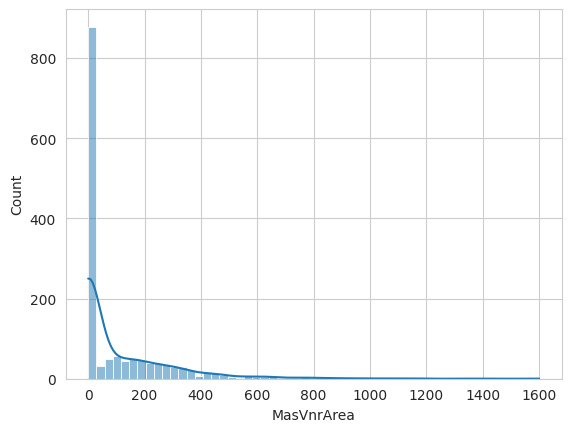

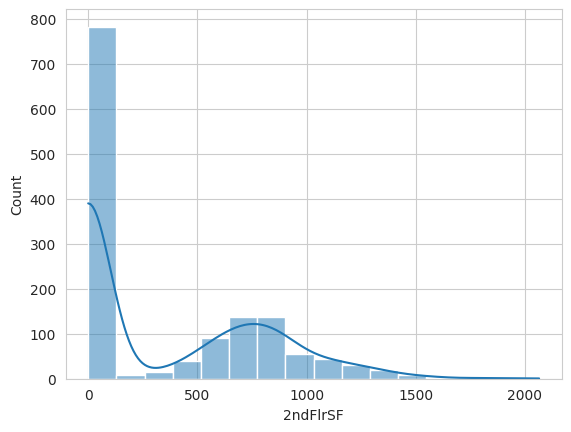

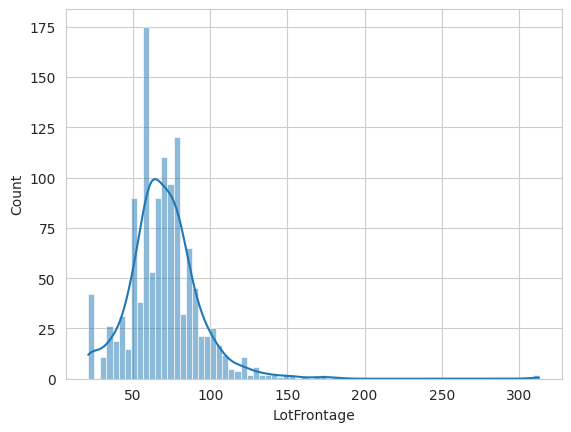

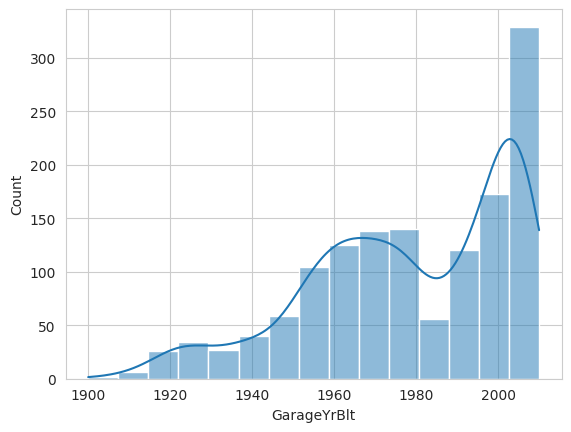

In [23]:
sns.set_style('whitegrid')
for col in ['MasVnrArea', '2ndFlrSF', 'LotFrontage', 'GarageYrBlt']:
  sns.histplot(data=df, x=col, kde=True)
  plt.show()
  print('\n')

In [24]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
      ( 'MasVnrArea',  ArbitraryNumberImputer(arbitrary_number=0,
                                                  variables=['MasVnrArea']) ),
      ( '2ndFlrSF',  ArbitraryNumberImputer(arbitrary_number=0,
                                                  variables=['2ndFlrSF']) ),
      ( 'GarageYrBlt',  ArbitraryNumberImputer(arbitrary_number=0,
                                                  variables=['GarageYrBlt']) ),
      ( 'LotFrontage',  ArbitraryNumberImputer(arbitrary_number=0,
                                                  variables=['LotFrontage']) ),                                                                                                                                   
])
pipeline

Pipeline(steps=[('MasVnrArea',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['MasVnrArea'])),
                ('2ndFlrSF',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('GarageYrBlt',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['GarageYrBlt'])),
                ('LotFrontage',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['LotFrontage']))])

In [25]:
pipeline.fit(df)

Pipeline(steps=[('MasVnrArea',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['MasVnrArea'])),
                ('2ndFlrSF',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['2ndFlrSF'])),
                ('GarageYrBlt',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['GarageYrBlt'])),
                ('LotFrontage',
                 ArbitraryNumberImputer(arbitrary_number=0,
                                        variables=['LotFrontage']))])

In [26]:
df = pipeline.transform(df)

In [27]:
df[['MasVnrArea', '2ndFlrSF', 'LotFrontage', 'GarageYrBlt']].isnull().sum()

MasVnrArea     0
2ndFlrSF       0
LotFrontage    0
GarageYrBlt    0
dtype: int64

MasVnrArea, 2ndFlrSF and GarageYrBlt all have the missing data cells replaced with 0

## BsmtExposure

In [28]:
df['BsmtExposure'].value_counts()

BsmtExposure
No    953
Av    221
Gd    134
Mn    114
Name: count, dtype: int64

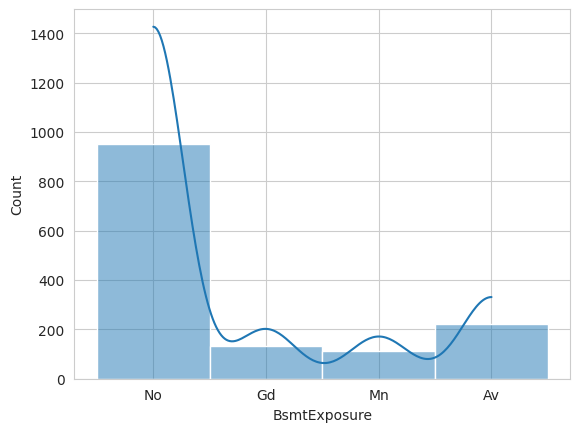

In [29]:
sns.set_style('whitegrid')
for col in ['BsmtExposure']:
  sns.histplot(data=df, x=col, kde=True)
  plt.show()
  print('\n')

In [30]:
from feature_engine.imputation import CategoricalImputer

pipeline = Pipeline([
      ( 'categorical_imputer', CategoricalImputer(imputation_method='frequent',
                                                  variables=['BsmtExposure']) )
])


df = pipeline.fit_transform(df)

In [31]:
df['BsmtExposure'].value_counts()

BsmtExposure
No    991
Av    221
Gd    134
Mn    114
Name: count, dtype: int64

## BsmtFinType1

In [32]:
df['BsmtFinType1'].value_counts()

BsmtFinType1
Unf    396
GLQ    385
ALQ    202
BLQ    136
Rec    126
LwQ     70
Name: count, dtype: int64

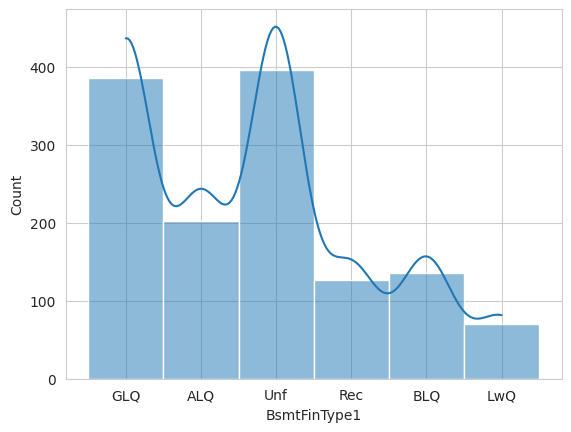

In [33]:
sns.set_style('whitegrid')
for col in ['BsmtFinType1']:
  sns.histplot(data=df, x=col, kde=True)
  plt.show()
  print('\n')

In [34]:
from feature_engine.imputation import CategoricalImputer

pipeline = Pipeline([
      ( 'categorical_imputer', CategoricalImputer(imputation_method='frequent',
                                                  variables=['BsmtFinType1']) )
])


df = pipeline.fit_transform(df)

In [35]:
df['BsmtExposure'].value_counts()

BsmtExposure
No    991
Av    221
Gd    134
Mn    114
Name: count, dtype: int64

## GarageFinish

In [36]:
df['GarageFinish'].value_counts()

GarageFinish
Unf    546
RFn    366
Fin    313
Name: count, dtype: int64

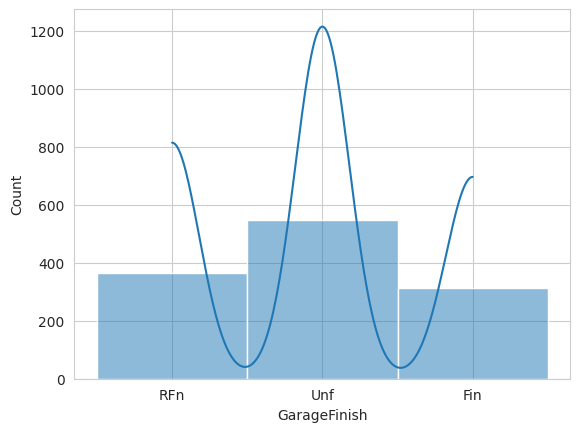

In [37]:
sns.set_style('whitegrid')
for col in ['GarageFinish']:
  sns.histplot(data=df, x=col, kde=True)
  plt.show()
  print('\n')

In [38]:
from feature_engine.imputation import CategoricalImputer

pipeline = Pipeline([
      ( 'categorical_imputer', CategoricalImputer(imputation_method='frequent',
                                                  variables=['GarageFinish']) )
])


df = pipeline.fit_transform(df)

In [39]:
df['GarageFinish'].value_counts()

GarageFinish
Unf    781
RFn    366
Fin    313
Name: count, dtype: int64

### Data Cleaning Summary

List here the data cleaning approaches you want initially to try.
* Drop - `['EnclosedPorch', 'WoodDeckSF']`


**The list above is your guide, your map to know at which stage you are in the data-cleaning process**

### Split Train and Test Set

In [40]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


In [41]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 2 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64


### Drop Variables


* Hint: you may drop Variables with more than 80% of missing data since these variables will likely not add much value. However, this is not the case in this dataset
* Step 1: imputation approach: **Drop Variables**
* Step 2: Select variables to apply the imputation approach

In [42]:
variables_method = ['EnclosedPorch', 'WoodDeckSF']

print(f"* {len(variables_method)} variables to drop \n\n"
    f"{variables_method}")


* 2 variables to drop 

['EnclosedPorch', 'WoodDeckSF']


* Step 3: Create a separate DataFrame applying this imputation approach to the selected variables.

In [43]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

* Step 4: Assess the effect on the variable's distribution.

* In this case, there is no effect on the distribution of the variable, since you are not removing rows, but columns.
* The effect might be losing features that might have a relevant impact on your machine-learning model.

* Step 5: If you are satisfied, apply the transformation to your data.

In [44]:
from feature_engine.selection import DropFeatures
imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

* Step 6: Evaluate if you have more variables to deal with. If yes, iterate. If not, you are done.

In [45]:
EvaluateMissingData(TrainSet)

,RowsWithMissingData,PercentageOfDataset,DataType


# Push cleaned data to Repo

In [46]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned') # create outputs/datasets/collection folder
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/datasets/cleaned'


## Train Set

In [47]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Test Set

In [48]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)